In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/MyDrive/10708/Project/10708 Project"  
!ls

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1x-yaBmrS6rdaY_q0Fr-WPA35kC8XWgYp/10708 Project
'10708 Project Brainstorming.gdoc'   GAN-robustness
 baseline_drum.ipynb		     grovae
 baseline.ipynb			     hmm
 baseline_piano.ipynb		     midway_report_generated_audio
'Copy of VAE.ipynb'		     piano
 drum				     robustness_samples
 GAN_piano_dssize.ipynb		     robustness_sampling_and_results.ipynb
 GAN_piano_noise.ipynb		     spoken_mnist
 GAN_results			    'Untitled Folder'
 GAN_results_drum		     VAE.ipynb
 GAN_results_piano		    'VAE output'
 GAN_results_piano_dssize	     VAE_results
 GAN_results_piano_robustness


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import PIL
import time
import math
import sys
import json
import pickle
import os

import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # this should be 'cuda'

cuda


In [ ]:
'''
Create custom dataset/loaders for the spoken_mnist data
'''
class SpokenMNIST_DS(Dataset):
  def __init__(self, files, sr=2**12, output_len=2**12): # sampling rate and waveform length at 16384
    '''
    files: a list of the file names (NO DIRECTORY PREFIXES!) in the dataset 
      # ASSUMES THE WORKING DIRECTORY IS THE '.../10708 Project' folder
      # Make sure the cells at the beginning reflect this
    sr: the resampling rate for librosa to use; 
    output_len: common length for the data samples; should be a power of 2 
    We pad/truncate each raw sample appropriately
    '''
    self.d = output_len
    self.sr = sr

    

    # self.files = list(os.listdir("spoken_mnist") )
    self.files = files
    self.n = len(self.files)



  def __len__(self):
    return(self.n)
  
  def __getitem__(self, i):
    
    path = os.path.join(data_fn , self.files[i]) 
    x, _ = librosa.load(path,sr=self.sr)

    if len(x)>self.d: # truncate if too long
      x=x[:self.d]
    elif len(x)<self.d: # pad if too short
      x = np.pad(x, (0, self.d-len(x)) )
    
    x=x.reshape(-1) # shape (1, d)
    label = int(self.files[i][0] )

    return x, label

dataset = SpokenMNIST_DS(files=list(os.listdir(data_fn) ))
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

**Resample raw audio to 4s chunks**

In [ ]:
import glob
import soundfile as sf
files = glob.glob('drum/**/*.wav', recursive=True)
print(len(files))

chunk_len=4

for i in range(19):
    path = "piano/raw/" + str(i).rjust(2, "0") + ".wav"
    x, sr = librosa.load(path , sr=2**14)

    for j in range(int(len(x)/ (chunk_len*2**14) )):
        chunk = x[j*chunk_len*2**14:(j+1)*chunk_len*2**14]
        sf.write("piano/chunks-4s/{}_{}.wav".format( i, j)  , chunk, 2**14)


In [3]:
from IPython.display import display, Audio, HTML

'''
Call this function to listen to sounds, either raw or generated
x is the numpy array holding the raw waveform
'''
def sound( x, rate, label=''):
    display(HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))


In [6]:
'''
Create custom dataset/loaders for the drum data
'''
import glob
class Piano_DS(Dataset):
    def __init__(self, files, sr=2**14, output_len=2**14): # sampling rate and waveform length at 4096 or 16384 
        '''
        files: a list of the file names (NO DIRECTORY PREFIXES!) in the dataset 
          # ASSUMES THE WORKING DIRECTORY IS THE '.../10708 Project' folder
          # Make sure the cells at the beginning reflect this
        sr: the resampling rate for librosa to use; 
        output_len: common length for the data samples; should be a power of 2 
        We pad/truncate each raw sample appropriately
        '''
        self.d = output_len
        self.sr = sr
        self.files = files
        self.n = len(self.files)

    def __len__(self):
        return(self.n)
  
    def __getitem__(self, i):
    
        path = self.files[i]
        x, _ = librosa.load(path,sr=self.sr)

        if len(x)>self.d: # truncate if too long
            x=x[:self.d]
        elif len(x)<self.d: # pad if too short
            x = np.pad(x, (0, self.d-len(x)) )

        x=x.reshape(1, -1) # shape (1, d)
        # label doesnt matter here
        label = -1

        return x, label

dataset = Piano_DS(files=glob.glob('piano/chunks-4s/*.wav', recursive=True), sr=2**12, output_len=2**14 )

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
for i, batch in enumerate(dataloader):
    if i==3:
        break
    sound(batch[0][0], rate=2**12)

""


""


""


In [8]:
class VAE(nn.Module):
  
    
    def __init__(self, in_shape, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
                        nn.Linear(in_shape, 2048),
                        nn.ReLU(),
                        nn.Linear(2048, 1024),
                        nn.ReLU(),
                        nn.Linear(1024, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        # nn.ReLU(),

                       
        )
        self.mu_x = nn.Linear(256, latent_dim)
        self.sigma_x = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
                        # nn.ReLU(),
                        nn.Linear(latent_dim, 256),
                        nn.ReLU(),
                        nn.Linear(256, 512),
                        nn.ReLU(),
                        nn.Linear(512, 1024),
                        nn.ReLU(),
                        nn.Linear(1024, 2048),
                        nn.ReLU(),
                        nn.Linear(2048, in_shape)
        )

    def sample(self, eps, sigmoid=False):
        if  eps is None:
            eps = torch.normal(0, 1, size=(1, self.latent_dim))
        return self.decode(eps, sigmoid)

    def encode(self, X):
        x = self.encoder(X)
        mean = self.mu_x(x)
        logvar = self.sigma_x(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = torch.normal(0, 1, size=mean.shape)
        return eps * torch.exp(logvar * 0.5) + mean
    
    def decode(self, Z, sigmoid=False):
        logits = self.decoder(Z)
        if sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def generate(self, x):
        mean, logvar = model.encode(x)
        print(mean, logvar)
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z, 0)
        return x_logit


def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = torch.log(torch.Tensor([2. * np.pi]))
        return torch.sum(
            -.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi),
            raxis)


def compute_loss(model, x):
        xx = torch.Tensor(x)
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z, 1)
        # print(x_logit)
        # print(x.shape)
   
        # logpx_z = nn.BCELoss( reduction="sum")
        logpx_z = F.binary_cross_entropy(x_logit, xx, reduction='mean')
        # logpx_z = logpx_z(x_logit, x)
        # logpx_z = F.mse_loss(x_logit, x)
        # # print(logpx_z)
        # logpx_z = -torch.sum(logpx_z)
        # logpz = log_normal_pdf(z, torch.Tensor([0]),  torch.Tensor([1]))
        # logqz_x = log_normal_pdf(z, mean, logvar)
        kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        # return -torch.mean(-logpx_z + logpz - logqz_x)
        print(logpx_z)
        print( 0.0001 * kl)
        return   logpx_z +  10 * kl


img_shape = 2**14
latent_dim = 2
model = VAE(img_shape, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# if torch.cuda.is_available():
#     model.cuda()

def train(epoch, model):
    model.train()
    train_loss = 0    
    for batch_idx, (x, y) in enumerate(dataloader):

        optimizer.zero_grad()

        loss = compute_loss(model, x)

        # Backpropagation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(x)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    return train_loss



    


In [13]:
# %ls '/content/drive/MyDrive/10708/Project/10708 Project/VAE_results'
PATH = '/content/drive/MyDrive/10708/Project/10708 Project/VAE_results/model_30.pt'

In [ ]:
load = 1
epoch = 0
if load:
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
l = []
for e in range(epoch, epoch + 30):
    l += [train(e, model)]
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'loss': LOSS,
            }, f'/content/drive/MyDrive/10708/Project/10708 Project/VAE_results/model_{e}.pt')
    


16384


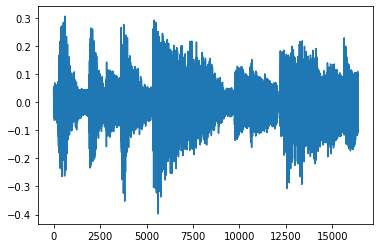

tensor([[ 0.0260,  0.0498, -0.0294,  ..., -0.0076, -0.0528, -0.0727]])


""


tensor([ 0.0058, -0.0075], grad_fn=<AddBackward0>) tensor([ 0.0075, -0.0114], grad_fn=<AddBackward0>)
[-33.09945   -30.779436   -4.3575344 ... -27.897099  -13.012528
 -33.77939  ]


""


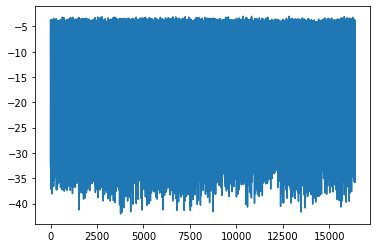

In [15]:
model.eval()

for d in dataloader:
    x = d[0][0][0]
    print(len(x.detach().numpy()))

    plt.figure()
    plt.plot(range(len(x.detach().numpy())), x.detach().numpy())
    plt.show()
    print(d[0][0])
    # print)
    sound(x,rate=2**12)
    xx = model.generate(x).detach().numpy()
    print(xx)
    sound(xx,rate=2**12)
    plt.figure()
    plt.plot(range(len(xx)), xx)
    plt.show()

    break